In [1]:
import numpy as np
import torch
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import librosa
import random
from scipy.optimize import minimize

# for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

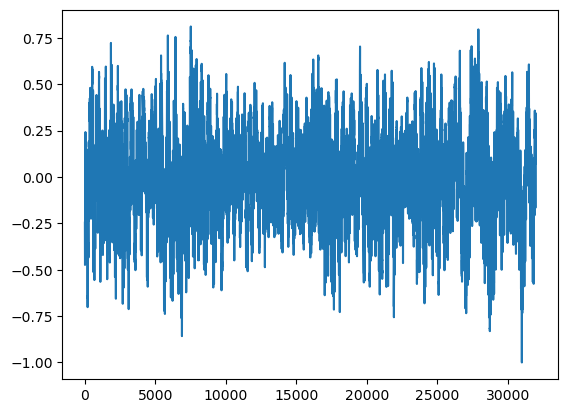

In [2]:
import cfg_dereverb as cfgs
# filename = "D:/datas/20250203_정보섬/org.wav"
filename = "D:/datas/drone_anomaly/eval_B_Back_normal_000005.wav"
signal, fs = librosa.load(filename, sr = None)
# signal = librosa.resample(signal, orig_sr = fs, target_sr = cfgs.fs)

signal = np.array(signal)

plt.plot(signal)
                          
# listen to the speech signal
Audio(filename)

In [9]:
import cfg_dereverb as cfgs
import numpy as np
import filterbank
import lib
import estimator

p = np.hanning(512)

''' Signal processing
% The algorithm itself is real-time capable, i.e., no processing of the entire
% utterance is necessary. Here however, for efficiency of the MATLAB implementation,
% the entire signal is processed at once.
'''
x = signal
x = x.reshape(1,-1)
# analysis filterbank
X=filterbank.DFTAnaRealEntireSignal(x,cfgs.K,cfgs.N,p)

# estimate PSD and coherence
Pxx = lib.estimate_psd(X,cfgs.nr["lambda"])
# Cxx = lib.estimate_cpsd(X[0,:,:],X[1,:,:],cfgs.nr["lambda"])/np.sqrt(Pxx[0,:,:]*Pxx[1,:,:])
Cxx = lib.estimate_temporal_coherence(X, cfgs.nr["lambda"])  # 새로운 coherence 추정 함수 필요

frequency = np.linspace(0,cfgs.fs/2,int(cfgs.K/2+1)) # frequency axis

# define coherence models
Css = np.exp(1j * 2 * np.pi * frequency * cfgs.TDOA)              # target signal coherence; not required for estimate_cdr_nodoa
Cnn = np.sinc(2 * frequency * cfgs.d_mic/cfgs.c) # diffuse noise coherence; not required for estimate_cdr_nodiffuse
Cnn = Cnn.reshape(1,-1)
print(Cxx.shape)
# apply CDR estimator (=SNR)
SNR = estimator.estimate_cdr_nodoa(Cxx, Cnn)
SNR = np.maximum(np.real(SNR),0)

weights = lib.spectral_subtraction(SNR,alpha = 2, beta = 1,mu = cfgs.nr["mu"])
weights = np.maximum(weights,cfgs.nr["floor"])
weights = np.minimum(weights,1)
print(weights.shape)
# postfilter input is computed from averaged PSDs of both microphones
Postfilter_input = np.sqrt(np.abs(X)**2)*np.exp(1j*np.angle(X[0,:,:]))
Postfilter_input = Postfilter_input.squeeze()
print('postfilt',Postfilter_input.shape)
# apply postfilter
Processed = weights*Postfilter_input

# synthesis filterbank
y = filterbank.DFTSynRealEntireSignal(Processed,cfgs.K,cfgs.N,p)

import time
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 타이머 시작
start_time = time.time()

# (여기에 신호 처리 코드 수행)

# 처리 완료 메시지
print(f"done ({time.time() - start_time:.2f}s)")

# 오디오 저장
y = np.real(y).astype(np.float32)

sf.write("D:/multi_source_localization/ICEIC-2025/out.wav", y, cfgs.fs)

# 시각화
plt.figure(figsize=(10, 6))

# Estimated CDR (=SNR) [dB]
plt.subplot(2, 1, 1)
plt.imshow(10 * np.log10(SNR), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="dB")
plt.clim(-15, 15)
plt.title("Estimated CDR (=SNR) [dB]")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

# Filter Gain
plt.subplot(2, 1, 2)
plt.imshow(weights, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="Gain")
plt.clim(0, 1)
plt.title("Filter Gain")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

plt.tight_layout()
plt.show()

(1, 250, 257)
(1, 250, 257)
postfilt (250, 257)
(1, 498, 257)


d:\multi_source_localization\dereverb\dereverberation\estimator.py:51: RuntimeWarning: invalid value encountered in divide
  magnitude_threshold * Cxx / np.abs(Cxx),


ValueError: operands could not be broadcast together with shapes (1,498,257) (512,) 

In [ ]:
# Test room parameters
room_dim= [10.0, 10.0, 5.0]
t60 = 1.0 #seconds
snr = 0 # dB

# Microphone locations
mic_locs = np.array([[1.0,1.0,1.0], [9.0,9.0,1.0]]).T

# Sound source position at the same hight
source_loc = np.array([5.0,5.0,2.5])

# Create the virtual room
e_absorption, max_order = pra.inverse_sabine(t60, room_dim)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(
    e_absorption), max_order=max_order)

c = room.c #speed of sound

room.add_source(source_loc, signal=signal)
room.add_microphone(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
plt.title('Virtual room')
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.title('From above')
plt.legend()
plt.show()

In [ ]:
room.plot_rir()
h = room.rir

In [ ]:
room.simulate(snr=snr)

m = room.mic_array.signals
plt.plot(m[0])

# Pick a 2048 samples long snippet
sig_len = fs*5
start_idx = 20000
end_idx = start_idx + sig_len

x = torch.Tensor(m[:, start_idx:end_idx])
print(x.shape)
plt.plot(range(start_idx,end_idx), x[0].squeeze())
plt.title("Signal received at mic 0")

In [ ]:
print(x.shape)
Audio(x[0], rate = fs)

In [ ]:
import cfg_dereverb as cfgs
import numpy as np
import filterbank
import lib
import estimator

p = np.hanning(512)

''' Signal processing
% The algorithm itself is real-time capable, i.e., no processing of the entire
% utterance is necessary. Here however, for efficiency of the MATLAB implementation,
% the entire signal is processed at once.
'''
x = signal
# analysis filterbank
X=filterbank.DFTAnaRealEntireSignal(x,cfgs.K,cfgs.N,p)
print(X.shape)
# estimate PSD and coherence
Pxx = lib.estimate_psd(X,cfgs.nr["lambda"])
# Cxx = lib.estimate_cpsd(X[0,:,:],X[1,:,:],cfgs.nr["lambda"])/np.sqrt(Pxx[0,:,:]*Pxx[1,:,:])
Cxx = lib.estimate_temporal_coherence(X, cfgs.nr["lambda"])  # 새로운 coherence 추정 함수 필요

frequency = np.linspace(0,cfgs.fs/2,int(cfgs.K/2+1)) # frequency axis

# define coherence models
Css = np.exp(1j * 2 * np.pi * frequency * cfgs.TDOA)              # target signal coherence; not required for estimate_cdr_nodoa
Cnn = np.sinc(2 * frequency * cfgs.d_mic/cfgs.c) # diffuse noise coherence; not required for estimate_cdr_nodiffuse
Cnn = Cnn.reshape(1,-1)

# apply CDR estimator (=SNR)
SNR = estimator.estimate_cdr_nodoa(Cxx, Cnn)
SNR = np.maximum(np.real(SNR),0)

weights = lib.spectral_subtraction(SNR,alpha = 2, beta = 1,mu = cfgs.nr["mu"])
weights = np.maximum(weights,cfgs.nr["floor"])
weights = np.minimum(weights,1)

# postfilter input is computed from averaged PSDs of both microphones
Postfilter_input = np.sqrt(np.mean(np.abs(X)**2,0))*np.exp(1j*np.angle(X[0,:,:]))

# apply postfilter
Processed = weights*Postfilter_input

# synthesis filterbank
y = filterbank.DFTSynRealEntireSignal(Processed,cfgs.K,cfgs.N,p)

import time
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 타이머 시작
start_time = time.time()

# (여기에 신호 처리 코드 수행)

# 처리 완료 메시지
print(f"done ({time.time() - start_time:.2f}s)")

# 오디오 저장
y = np.real(y).astype(np.float32)

sf.write("D:/multi_source_localization/ICEIC-2025/out.wav", y, cfgs.fs)

# 시각화
plt.figure(figsize=(10, 6))

# Estimated CDR (=SNR) [dB]
plt.subplot(2, 1, 1)
plt.imshow(10 * np.log10(SNR), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="dB")
plt.clim(-15, 15)
plt.title("Estimated CDR (=SNR) [dB]")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

# Filter Gain
plt.subplot(2, 1, 2)
plt.imshow(weights, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label="Gain")
plt.clim(0, 1)
plt.title("Filter Gain")
plt.xlabel("Frame Index")
plt.ylabel("Subband Index")

plt.tight_layout()
plt.show()

In [ ]:
print(y.shape)


print(np.min(y), np.max(y)) 
Audio(y, rate = cfgs.fs)



In [ ]:
Audio(signal, rate = cfgs.fs)

In [ ]:
Audio(x[0], rate = fs)

In [ ]:
import numpy as np
import scipy.signal as signal

def compute_elr(signal, rir, fs, early_ms=50):
    """
    Compute ELR using RIR-based early and late reflections.
    
    Parameters:
        signal (numpy.ndarray): Input speech signal
        rir (numpy.ndarray): Room Impulse Response (RIR)
        fs (int): Sampling frequency in Hz
        early_ms (int): Early reflections window in milliseconds (default: 50ms)
    
    Returns:
        elr (float): Early-to-Late Reverberation Ratio in dB
    """
    # RIR 최대값(Direct Path) 위치 찾기
    ind_max = np.argmax(np.abs(rir)) 
    
    # 초기 반사음 구간 설정 (밀리초 -> 샘플 변환)
    ind_early = round(early_ms / 1000 * fs)
    
    # 초기 반사음과 후기 반사음 분리
    h_early = rir[ind_max : min(ind_max + ind_early, len(rir))]
    h_late = rir[min(ind_max + ind_early, len(rir)):]
    
    # 신호에 초기 반사음 및 후기 반사음 적용 (컨볼루션)
    y_early = signal.convolve(signal, h_early, mode="same")
    y_late = signal.convolve(signal, h_late, mode="same")

    # 에너지 계산
    E_early = np.sum(y_early ** 2)
    E_late = np.sum(y_late ** 2)

    # ELR 계산
    if E_late > 0:
        elr = 10 * np.log10(E_early / E_late)
    else:
        elr = np.nan  # 후기 반사음이 없으면 NaN 반환
    
    return elr


In [ ]:
# Example usage
print(fs)
h1 = room.rir[0]
h2 = room.rir[1]

elr1, h_cut = elr_calc(h1, fs)
elr2, h_cut = elr_calc(h2, fs)
print(f"ELR: {elr1:.2f} dB")
print(f"ELR: {elr2:.2f} dB")

In [6]:
import os

data_root = 'D:/datas/librispeech/LibriSpeech/'
split = 'test-clean'
split_dir = os.path.join(data_root, split)
for speaker_id in os.listdir(split_dir):
    speaker_dir = os.path.join(split_dir, speaker_id)
    for chapter_id in os.listdir(speaker_dir):
        chapter_dir = os.path.join(speaker_dir, chapter_id)
        for filename in os.listdir(chapter_dir):
            if filename.endswith(".flac"):
                full_path = os.path.join(chapter_dir, filename)
                utterance_id = int(filename.replace(".flac", ""))
                print(utterance_id)

ValueError: invalid literal for int() with base 10: '1089-134686-0000'